# Линейна регресия на много променливи

На предишният ThinkFriday разгледахме линейна регресия на една променлива. Също така генерализирахме формулата за хипотезата на линейна регсия, така че да работи с множество атрибути. За домашно имахме да имплементираме линейна регресия на много променливи, като за обучаващи данни трябваше да използваме данните от файл houseprices2.txt
Сега нака да разгледаме решението на домашното.

In [44]:
# обичайните заподозрени 
# с тези импорти започваме почти всеки ноутбук
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline

Нека първо да заредим данните. Правим това с помоща на библиотеката pandas и функция read_csv(). Файлът с данни не съдържа заглавен ред и затова ръчно задаваме етикети на колоните - размер, брой стаи и цена. Заредените по този начин данните се съхраняват в обект - dataframe. С извикване на функцията head() можем да видим първите няколко реда от данните.

In [45]:
path = os.getcwd() + '/houseprices2.txt'  
df = pd.read_csv(path, header=None, names=['Size', 'Rooms', 'Price'])  
df.head()  

,Size,Rooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


Друга полезна финцкия на pandas е describe(), която ни дава някои базови статистически данни за множеството. Това е полезно за да придобием представа с какви данни си имаме работа.

In [46]:
df.describe()

,Size,Rooms,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


Обърнете внимание че стойностите в различните колони са в много различен порядък. Броят на стаите е $10^1$. Размерът е в порядък $10^3$, а цената e в порядък $10^5$. Ако приложим линейна регресия върху тези данни директно приносът на "размер" ще бъде непропрционално голям спрямо "брой стаи". За да решим този проблем правим нормализация да данните. Тоест искаме всички данни да бъдат в една и съща скала. Обикновенно нормализацията се прави като от всяка стойност на даден атрибут се извади средната стойност за атрибута и след това получената стойност се раздели на стандартното отклонение. Формулата е написана по-долу.

$$x'= \frac {x - \bar{x}}{\sigma}$$ 

Използвайки pandas това се прави на един ред.

In [47]:
histData = df.copy(deep=True)

#df = (df - df.mean()) / df.std()  
df = (df - df.mean()) / (df.max() - df.min())  
df.head()  

,Size,Rooms,Price
0,0.028494,-0.042553,0.112240
1,-0.110502,-0.042553,-0.019835
2,0.110127,-0.042553,0.053938
3,-0.161247,-0.292553,-0.204552
4,0.275598,0.207447,0.376391


След това трябва да модифицираме имплементацията на линейната регресия, така че да работи с множество независими променливи. Нека да видм кода на градиентното спускане.

In [48]:

def compute_cost(X, y, theta):  
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

def gradient_descent(X, y, theta, alpha, num_iters):  
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(num_iters)

    for i in range(num_iters):
        error = (X * theta.T) - y

        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))

        theta = temp
        cost[i] = compute_cost(X, y, theta)

    return theta, cost

Нека да разгледаме кода изчисляващ грешката - това е имплементирано във функцията compute_cost. Тук използваме умножение на матрици макар това да не e очевидно на пръв поглед. Този код ще работи коректно без значение колко променливи (колони) има X, стига броят на параметрите за theta да бъде същият, като броят на променливите в X.

Ценовата функция от предишната лекция може да бъде използвана директо. Тук обаче сме я пренаписали, като изпозваме матрично умножение от пакета numpy. Това е така наречената векторизирана имплементация. Тази имплементация е изключеително бърза тък като numpy е високо оптимизиран пакет за линейна алгебра.

Нака да проверим какво сме направили. Първо трябва да инициализираме няколко матрици, които да подаваме на нашите функции.

In [49]:
# добявме една нова колона с единници
# това е изкуственият параметър x0
df.insert(0, 'Ones', 1)

# сетваме X (обучаващите данни) и y (целевата променлива)
cols = df.shape[1]  
X = df.iloc[:,0:cols-1]  
y = df.iloc[:,cols-1:cols]

# конвертираме стойностите в numpy матрици и инициализираме theta
X = np.matrix(X.values)  
y = np.matrix(y.values)  
theta = np.matrix(np.array([0,0,0]))  

Сега вече може да приложим линейната регресия.

In [50]:
# инициализираме променливи за скоростта на обучение и броят итерации
alpha = 0.5  
num_iters = 1000

# прилагаме градиентното спускане за множеството
g, cost = gradient_descent(X, y, theta, alpha, num_iters)

# изчисляваме грешката на модела
compute_cost(X, y, g) 

0.0072740479559596288

Сега можем да отпечатаме грешката като функция на броя итерации, за да се уверим, че грешката в действителност намалява в процеса на обучение на нашият модел.

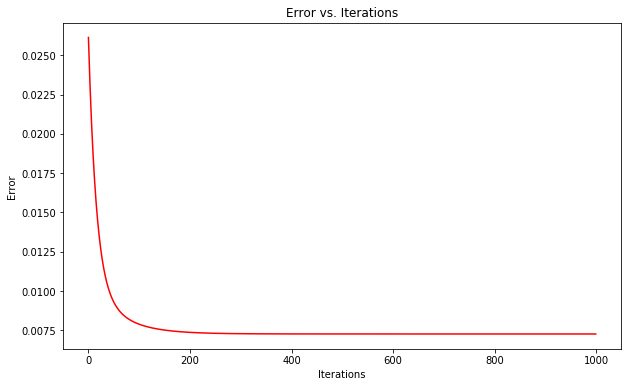

In [51]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.plot(np.arange(num_iters), cost, 'r')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Error')  
ax.set_title('Error vs. Iterations')  
plt.show()

Накрая визуализираме нашето предвиждане за цената на апартаментита, базирано на двете променливи - размер на жилището и брой стаи.

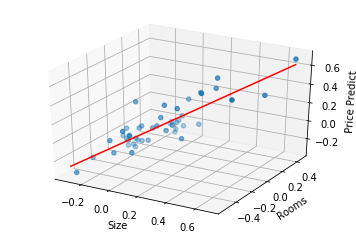

In [52]:
x = np.linspace(df.Size.min(), df.Size.max(), 100)  
y = np.linspace(df.Rooms.min(), df.Rooms.max(), 100)  
f = g[0, 0] + (g[0, 1] * x) + (g[0, 2] * y)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, f, 'r')  
ax.scatter(df.Size, df.Rooms, df.Price) 
ax.set_xlabel('Size')
ax.set_ylabel('Rooms')
ax.set_zlabel('Price Predict')
plt.show()

Когато правим предвиждания с нормализирани данни след като направим нашето предсказание е добре да извършим денормализация, така че да виждаме говорещи стойности за целевата променлива.

In [53]:
def denormalize(x, std, mean):
    return x * std + mean

dn = denormalize(-0.220817, 794.702354, 2000.680851)

print(dn)

xs = df.Size * histData.Size.std() + histData.Size.mean()
ys = df.Rooms * histData.Rooms.std() + histData.Rooms.mean() 
zs = df.Price * histData.Price.std() + histData.Price.mean()

1825.1970613
